<a href="https://colab.research.google.com/github/ITU-Business-Analytics-Team/Business_Analytics_for_Professionals/blob/main/Part%20II%20%3A%20Business%20Applications/Chapter%2011%3A%20Supply%20Chain%20Analytics/11_2_Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Supply Chain Analytics**
## Demand Forecasting

Fast-food company ABC has six restaurants in a district. Customers place orders on its Web site or mobile application. The company managers would like to optimize the number of carriers for each hour. Therefore, they should predict the hourly demand first. 



The list of variables used to predict demand is given below:

*   **WorkingDay:**  Workday information
*   **ClosedRestaurant:** Number of closed restaurants on a specific
hour
*   **WeatherCode:** General weather condition forecast (rainy,
sunny, cloudy, etc.)
*   **Day:** Day of month
*   **ReligiousHoliday:** Is there a religious holiday on that day
*   **Event:** Is there any event on that day
*   **Hour:** Hour of day
*   **Humidity:** Weather humidity forecast
*   **Rain:** Rain forecast
*   **Snow:** Snow forecast
*   **FootballMatch:** Is there any football match on that day
*   **Month:** Month of year
*   **Ramadan:** Is the day in Ramadan
*   **Holiday:** Is there a holiday on that day
*   **ExamDay:** Is it an exam day for students
*   **WinterHoliday:** Is there a semester holiday on that day
*   **Temperature:** Temperature forecast
*   **UnexpectedEvent:** Is there any other event on that day
*   **WeekDay:** Is it a weekday
*   **WindDirection:** Wind direction forecast
*   **Wind:** Wind speed forecast
*   **SummerHoliday:** Is there a summer holiday on that day
*   **Year:** Year
*   **NewYear:** Is there a Christmas on that day


In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import pandas as pd
import numpy as np 

import random as rn
import gc

from sklearn.preprocessing import MinMaxScaler

#Install tensorflow if not 
#!pip install tensorflow==2.2

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout

In [ ]:
#Import Data
url = "https://docs.google.com/spreadsheets/d/1fvhMf7wTk5X6CKrQaVjjH2B1d2KpDifH/edit?usp=sharing&ouid=110490639604271004553&rtpof=true&sd=true"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_excel(path, index_col="Time")
df.head()

,WorkingDay,ClosedRestaurant,WeatherCode,Day,ReligiousHoliday,Event,Hour,Humidity,Rain,Snow,...,WinterHoliday,Temperature,UnexpectedEvent,WeekDay,WindDirection,Wind,SummerHoliday,Year,NewYear,TotalOrder
Time,,,,,,,,,,,,,,,,,,,,,
2016-11-07 11:00:00,1,0,34,11,0,0,11,37,0,0,...,0,27,0,1,40,24,1,2016,0,1
2016-11-07 12:00:00,1,0,34,11,0,0,12,37,0,0,...,0,27,0,1,40,24,1,2016,0,8
2016-11-07 13:00:00,1,0,34,11,0,0,13,37,0,0,...,0,27,0,1,40,24,1,2016,0,14
2016-11-07 14:00:00,1,0,34,11,0,0,14,37,0,0,...,0,27,0,1,40,24,1,2016,0,8
2016-11-07 15:00:00,1,0,34,11,0,0,15,37,0,0,...,0,27,0,1,40,24,1,2016,0,14


In [ ]:
results = {}

In [ ]:
X = df.drop(columns=['TotalOrder'])
y = df[['TotalOrder']]

In [ ]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train_size, test_size

(5657, 1415)

In [ ]:
scaler_x = MinMaxScaler()
X_norm = scaler_x.fit_transform(X)
X_train, X_test = X_norm[:train_size], X_norm[train_size:]

y_true = y[train_size:]
scaler_y = MinMaxScaler()
y_norm = scaler_y.fit_transform(y)
y_train = y_norm[:train_size]

## Long Short Term Memory

Initially, hourly demand forecasts are obtained using the LSTM method based on
the data of the previous 12 h.  The error reduction graph for the train and test sets of the LSTM model is shown. 


In [ ]:
lookback=12
train_size = train_size - lookback + 1

In [ ]:
X_all=[]
y_all=[]
for i in range(len(X_norm)-lookback + 1):
    t=[]
    for j in range(0,lookback):
        t.append(X_norm[[(i+j)]])
    X_all.append(t)
    y_all.append(y_norm[i+ lookback - 1])

X_all, y_all= np.array(X_all), np.array(y_all)

y_pred=[]

X_train= X_all[:train_size]
X_test = X_all[train_size:train_size + test_size]
if lookback!=0:
    X_train = X_train.reshape(X_train.shape[0],lookback, X_train.shape[3])
    X_test = X_test.reshape(X_test.shape[0],lookback, X_test.shape[3])
else:
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])
    
y_train= y_all[:train_size]
y_test= y_all[train_size:]

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((5646, 12, 24), (1415, 12, 24), (5646, 1), (1415, 1))

In [ ]:
units=32
epochs=50
batch_size=72

In [ ]:
from matplotlib import pyplot

Train on 5646 samples, validate on 1415 samples
Epoch 1/50
5616/5646 [============================>.] - ETA: 0s - loss: 0.1595 - mae: 0.1595

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


5646/5646 [==============================] - 2s 369us/sample - loss: 0.1593 - mae: 0.1593 - val_loss: 0.0941 - val_mae: 0.0941
Epoch 2/50
5646/5646 [==============================] - 1s 199us/sample - loss: 0.1154 - mae: 0.1154 - val_loss: 0.0807 - val_mae: 0.0807
Epoch 3/50
5646/5646 [==============================] - 2s 343us/sample - loss: 0.1040 - mae: 0.1040 - val_loss: 0.0864 - val_mae: 0.0864
Epoch 4/50
5646/5646 [==============================] - 3s 472us/sample - loss: 0.0983 - mae: 0.0983 - val_loss: 0.0722 - val_mae: 0.0722
Epoch 5/50
5646/5646 [==============================] - 2s 404us/sample - loss: 0.0940 - mae: 0.0940 - val_loss: 0.0722 - val_mae: 0.0722
Epoch 6/50
5646/5646 [==============================] - 2s 436us/sample - loss: 0.0919 - mae: 0.0919 - val_loss: 0.0807 - val_mae: 0.0807
Epoch 7/50
5646/5646 [==============================] - 2s 424us/sample - loss: 0.0889 - mae: 0.0889 - val_loss: 0.0758 - val_mae: 0.0758
Epoch 8/50
5646/5646 [=======================

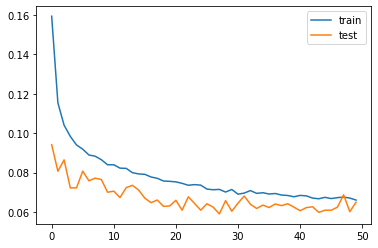

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


2842

In [ ]:
#Set random seed
sd=0
np.random.seed(sd)
rn.seed(sd)
os.environ['PYTHONHASHSEED']=str(sd)

config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=4, 
                                  inter_op_parallelism_threads=2, allow_soft_placement=True, device_count = {'CPU': 4 })

tf.compat.v1.set_random_seed(sd)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
tf.compat.v1.keras.backend.set_session(sess)

tf.compat.v1.disable_eager_execution()   

## LSTM Model & Prediction ###############
model = Sequential()

model.add(LSTM(units=units, input_shape=(lookback,X_all.shape[3]), dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['mae'])
    
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

y_pred= model.predict(X_test)
##########################################
        
y_pred = np.array(y_pred).reshape(test_size,1)

## Clear model, Keras & tensorflow ##############
del model
K.clear_session()
tf.compat.v1.reset_default_graph()   
gc.collect() 
######################################

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
y_pred = scaler_y.inverse_transform(y_pred)
results['LSTM'] = mean_absolute_error(y_pred,y_true)

In [ ]:
results

{'LSTM': 2.079400322041326}

Six other machine learning techniques are also included to forecast:

*   Multi Layer Perceptron (MLP)
*   Ridge Regression
*   Support Vector Machine (SVR)
*   Decision Tree
*   Random Forest (RF)
*   Extreme Gradient Boosting (XGB) 
*   Light Gradient Boosting (LGB)


## Multi Layer Perceptron (MLP)

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
X_train, X_test = X_norm[:train_size], X_norm[train_size:]
                
y_train = y_norm[:train_size]
y_true = y[train_size:]

In [ ]:
### MLP

regressor = MLPRegressor(random_state=0,hidden_layer_sizes=(1,10))
regressor.fit(X_train, y_train.ravel())

y_pred = regressor.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred.reshape(y_pred.shape[0],1))

In [ ]:
results['MLP'] = mean_absolute_error(y_pred,y_true)
results

{'LSTM': 2.079400322041326, 'MLP': 2.773939027053658}

## Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
regressor = Ridge(random_state=0)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred.reshape(y_pred.shape[0],1))

In [ ]:
results['Ridge'] = mean_absolute_error(y_pred,y_true)
results

{'LSTM': 2.079400322041326,
 'MLP': 2.773939027053658,
 'Ridge': 3.2169041681973445}

## Support Vector Regression

In [ ]:
from sklearn.svm import SVR

In [ ]:
X_train, X_test = X[:train_size], X[train_size:]
                
y_train = y[:train_size]
y_true = y[train_size:]

In [ ]:
regressor = SVR()
regressor.fit(X_train, y_train.values.ravel())

y_pred = regressor.predict(X_test)

In [ ]:
results['SVR'] = mean_absolute_error(y_pred,y_true)
results

{'LSTM': 2.079400322041326,
 'MLP': 2.773939027053658,
 'Ridge': 3.2169041681973445,
 'SVR': 3.9644902002202107}

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
regressor = DecisionTreeRegressor(random_state=0,min_samples_split=10)
regressor.fit(X_train, y_train.values.ravel())

y_pred = regressor.predict(X_test)

In [ ]:
results['Desicion Tree'] = mean_absolute_error(y_pred,y_true)
results

{'Desicion Tree': 2.4364447672477128,
 'LSTM': 2.079400322041326,
 'MLP': 2.773939027053658,
 'Ridge': 3.2169041681973445,
 'SVR': 3.9644902002202107}

## Random Forests

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
regressor = RandomForestRegressor(n_estimators = 100,random_state = 0,min_samples_split=10)
regressor.fit(X_train, y_train.values.ravel())

y_pred = regressor.predict(X_test)

In [ ]:
results['Random Forests'] = mean_absolute_error(y_pred,y_true)
results

{'Desicion Tree': 2.4364447672477128,
 'LSTM': 2.079400322041326,
 'MLP': 2.773939027053658,
 'Random Forests': 2.0199710939992466,
 'Ridge': 3.2169041681973445,
 'SVR': 3.9644902002202107}

## Extreme Gradient Boosting (XGB)

In [ ]:
from xgboost import XGBRegressor

In [ ]:
regressor = XGBRegressor(n_estimators = 100,max_depth = 9,objective = 'reg:squarederror')
regressor.fit(X_train, y_train.values.ravel())

y_pred = regressor.predict(X_test)

In [ ]:
results['XGBoost'] = mean_absolute_error(y_pred,y_true)
results

{'Desicion Tree': 2.4364447672477128,
 'LSTM': 2.079400322041326,
 'MLP': 2.773939027053658,
 'Random Forests': 2.0199710939992466,
 'Ridge': 3.2169041681973445,
 'SVR': 3.9644902002202107,
 'XGBoost': 2.0912053341576295}

## Light Gradient Boosting Machines (LGB)


In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
regressor = LGBMRegressor(n_estimators = 100)
regressor.fit(X_train, y_train.values.ravel())

y_pred = regressor.predict(X_test)

In [ ]:
results['LGB'] = mean_absolute_error(y_pred,y_true)
results

{'Desicion Tree': 2.4364447672477128,
 'LGB': 1.9705170312991633,
 'LSTM': 2.079400322041326,
 'MLP': 2.773939027053658,
 'Random Forests': 2.0199710939992466,
 'Ridge': 3.2169041681973445,
 'SVR': 3.9644902002202107,
 'XGBoost': 2.0912053341576295}

In [ ]:
result_df = pd.DataFrame.from_dict(results,orient='index').reset_index()
result_df.columns = ['Method','MAE']
result_df.head(10)

,Method,MAE
0,LSTM,2.079400
1,MLP,2.773939
2,Ridge,3.216904
3,SVR,3.964490
4,Desicion Tree,2.436445
5,Random Forests,2.019971
6,XGBoost,2.091205
7,LGB,1.970517


Finally, comparing MAE values, it is seen that deep learning method
(LSTM) and ensemble methods (LGB, Random Forest, and XGBoost) are superior to
other techniques for this application. 